#Important Note:
This notebook references the following [notebook](https://www.kaggle.com/code/dikshabhati2002/song-lyrics-generator/notebook) for Data Acquisition and Visualization only.

# Data Acquisition


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import numpy as np 
import re

In [ ]:
file_path = '/content/gdrive/My Drive/CSC413FinalProject/lyrics-data.csv' 

In [ ]:
#file_path2 = '/content/gdrive/My Drive/Colab Notebooks/CSC413/lyrics-data.csv'

In [ ]:
##file_path_shared = '/content/gdrive/Shared with me/CSC413FinalProject/lyrics-data.csv'

In [ ]:
file_path3 = '/content/gdrive/My Drive/CSC413/lyrics-data.csv/lyrics-data.csv'

In [ ]:
data = pd.read_csv(file_path3)

In [ ]:
data.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [ ]:
data.drop(['ALink', 'SLink'],axis=1,inplace=True)

In [ ]:
data.shape

(379931, 3)

In [ ]:
data['language'].value_counts()

en     191814
pt     157393
es       9917
rw       1679
it       1432
fr       1225
de        844
fi        145
sv        112
ro         97
no         89
is         86
tl         69
pl         47
gl         36
ga         32
tr         32
id         26
cy         23
su         19
af         19
sw         19
ko         17
nl         14
da         13
ca         13
et         13
ms          8
ja          7
st          7
ht          5
gd          4
ru          4
ar          4
eu          4
cs          3
ku          3
ny          3
mg          3
lg          2
jw          2
hu          2
vi          1
iw          1
sr          1
hmn         1
hr          1
fa          1
sq          1
zh          1
lv          1
sl          1
Name: language, dtype: int64

## What about getting English-only songs?

In [ ]:
data = data[data['language']=='en']

In [ ]:
data['language'].value_counts()

en    191814
Name: language, dtype: int64

Now, we have only English lyrics in our dataset!

In [ ]:
subset = data[:1400]

Take a subset to look at.

In [ ]:
subset.shape

(1400, 3)

# Data Visualization

In [ ]:
subset['Number_of_words'] = subset['Lyric'].apply(lambda x:len(str(x).split()))
subset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,SName,Lyric,language,Number_of_words
69,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,299
86,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en,161
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,159
111,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,175
140,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,215


##How does the subset statistics look?

In [ ]:
subset['Number_of_words'].describe()

count    1400.000000
mean      418.931429
std       195.621704
min         8.000000
25%       279.750000
50%       399.000000
75%       536.250000
max      1495.000000
Name: Number_of_words, dtype: float64

Average song lyrics word count for the subset is 418, with a max count of 1495, min of 8.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

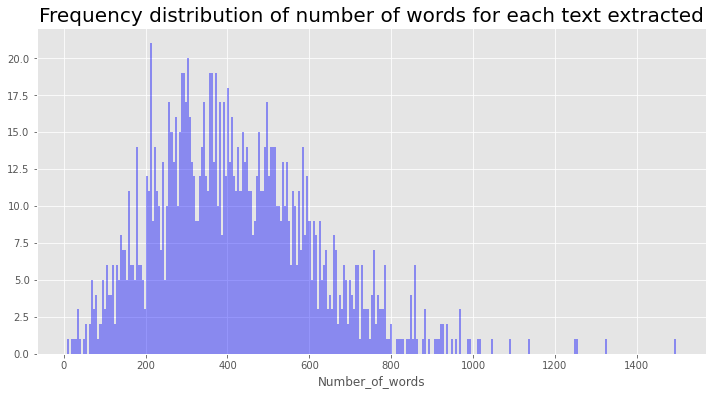

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(subset['Number_of_words'],kde = False,color="blue",bins=300)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

The distribution appears to be unimodal around the mean of 418, with some outliers in the >1000 word count range.

##How about the entire batch?

In [ ]:
data['Number_of_words'] = data['Lyric'].apply(lambda x:len(str(x).split()))
data.head()

,SName,Lyric,language,Number_of_words
69,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,299
86,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en,161
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,159
111,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,175
140,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,215


In [ ]:
data['Number_of_words'].describe()

count    191814.000000
mean        250.229159
std         159.288438
min           1.000000
25%         147.000000
50%         211.000000
75%         304.000000
max        3422.000000
Name: Number_of_words, dtype: float64

When examining all English songs, we can see a more normal looking distribution for what we might expect from song lyrics. Namely, the mean is a more modest 250, but of course, the max and min will be more extreme given the larger dataset. Nevertheless, the standard deviation is lower than the subset, as expected.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

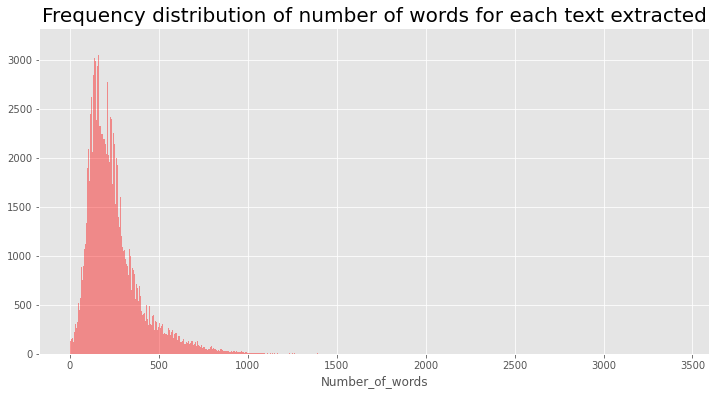

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="red",bins=1000)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

Once again, we see a unimodal distribution centered around the mean of 250, but with a longer right hand side tail (as there exists outliers in the >1000 word count range).

##How do we deal with outliers?

In [ ]:
data = data[data['Number_of_words'] <= 400]
data = data[data['Number_of_words'] >= 100]

We could choose to ignore outliers in the data, based on an arbitrary threshold (I picked a min of 10 words, and a max of 800 here).

In [ ]:
data['Number_of_words'].describe()

count    148828.000000
mean        216.623344
std          74.761524
min         100.000000
25%         156.000000
50%         205.000000
75%         268.000000
max         400.000000
Name: Number_of_words, dtype: float64

The total count still remains high, but now our standard deviation is lower.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

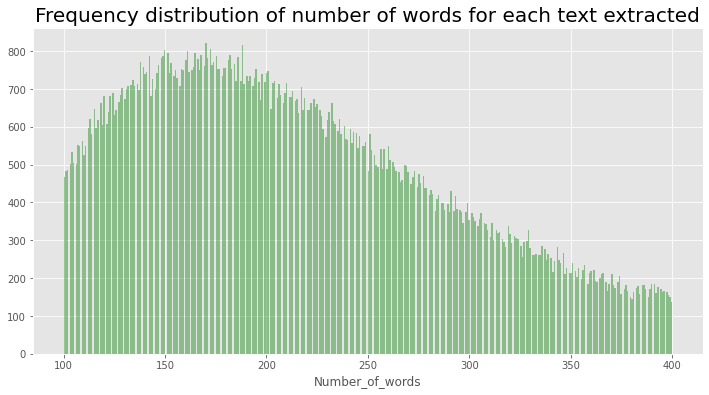

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="green",bins=400)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

This data modification results in a more normal looking dataset.

# Cleaning the Dataset

In [ ]:
data

,SName,Lyric,language,Number_of_words
69,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,299
86,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en,161
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,159
111,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,175
140,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,215
...,...,...,...,...
379926,The Waiting,Chorus\nHere we stand waiting on the plain\nDa...,en,198
379927,Too Early For The Sky,I nearly disappeared into the mouth of a croco...,en,137
379928,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i...",en,221
379929,When The System Has Fallen,Sweat in the heat for days on end\nwaiting for...,en,260


We want to build a valid vocabulary to simplify what kinds of characters the model has to learn.

In [ ]:
data2 = np.array(data["Lyric"])
all_words = "" 
for i in range(len(data2)):
    all_words+=data2[i]
corpus = all_words.lower()

In [ ]:
vocab=list(set(corpus))

In [ ]:
valid_vocab = "abcdefghijklmnopqrstuvwxyz1234567890,.?!@#$%^&*()_+-={}[]\/'"
valid_vocab = [char for char in valid_vocab]
valid_vocab.extend(['\n','"',' '])
accepted_chars = []
for v in vocab:
  if v in valid_vocab:
    accepted_chars.append(v)
#regex = "[a-z0-9,.\?\!;':\+\-/\(\)\[\]\{\}@#$%\^&\*]|[\n]"
#accepted_chars = re.findall(regex,''.join(vocab))
#accepted_chars.append(' ')

## Constraining the Dataset

Here, we are deciding to constrain our dataset to exclude any songs with unacceptable chars (i.e. not in our vocabulary).

In [ ]:
#not_needed_char = vocab[:]
#for i in accepted_chars:
#    not_needed_char.remove(i)
def has_invalid_char(lyrics):
  global valid_vocab
  corpus = lyrics.lower()
  vocab=list(set(corpus))
  for char in vocab:
    if char not in valid_vocab:
      return False
  return True
data['valid'] = data.apply(lambda row: has_invalid_char(row["Lyric"]), axis=1)


In [ ]:
data

,SName,Lyric,language,Number_of_words,valid
69,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,299,True
86,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en,161,False
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,159,True
111,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,175,True
140,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,215,True
...,...,...,...,...,...
379926,The Waiting,Chorus\nHere we stand waiting on the plain\nDa...,en,198,True
379927,Too Early For The Sky,I nearly disappeared into the mouth of a croco...,en,137,True
379928,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i...",en,221,False
379929,When The System Has Fallen,Sweat in the heat for days on end\nwaiting for...,en,260,False


In [ ]:
data_new = data.drop(data[data.valid == False].index)


In [ ]:
data_new.describe()

,Number_of_words
count,117708.000000
mean,215.165036
std,74.251521
min,100.000000
25%,155.000000
50%,204.000000
75%,266.000000
max,400.000000


We still have enough data points to work with.

In [ ]:
data_new

,SName,Lyric,language,Number_of_words,valid
69,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,299,True
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,159,True
111,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,175,True
140,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,215,True
159,Losing Control (Miss Cady feat. Ivete Sangalo),"Uh, yeah.\nGo, go, go.\nUh, yeah.\nUh, Uh, Uhh...",en,345,True
...,...,...,...,...,...
379921,Spirit Is The Journey,Ploughed the moon reached an island\nBalanced ...,en,273,True
379922,Take My Heart Away,Chorus\nTake my heart away (repeat)\n\nTo be t...,en,148,True
379923,Talk To The People,There's a brawl in a lonely whites only bar\nA...,en,213,True
379926,The Waiting,Chorus\nHere we stand waiting on the plain\nDa...,en,198,True


In [ ]:
data_new['Lyric']

69        I feel so unsure\nAs I take your hand and lead...
88        Baby, let's cruise, away from here\nDon't be c...
111       Know it sounds funny\nBut, I just can't stand ...
140       You've got that look again\nThe one I hoped I ...
159       Uh, yeah.\nGo, go, go.\nUh, yeah.\nUh, Uh, Uhh...
                                ...                        
379921    Ploughed the moon reached an island\nBalanced ...
379922    Chorus\nTake my heart away (repeat)\n\nTo be t...
379923    There's a brawl in a lonely whites only bar\nA...
379926    Chorus\nHere we stand waiting on the plain\nDa...
379927    I nearly disappeared into the mouth of a croco...
Name: Lyric, Length: 117708, dtype: object

## Character-level Summary Statistics

In [ ]:
data_new = data_new['Lyric']

In [ ]:
avg = 0
i = 0
max_cc = 0
min_cc = 500
for data in data_new:
  char_count = len(data)
  i += 1
  avg += char_count
  if (char_count > max_cc):
    max_cc = char_count 
  elif (char_count < min_cc):
    min_cc = char_count
  

avg = avg / i
std = 0
for data in data_new: 
  std += pow(len(data) - avg, 2)

std = pow(std / i, 0.5)
print("Average character length: ", avg)
print("Standard deviation: ", std)
print("Max: ", max_cc)
print("Min: ", min_cc)

Average character length:  1078.9384238964217
Standard deviation:  371.15197966353367
Max:  3273
Min:  365


Generating some summary statistics on our newly constrained dataset breaks down our word lengths into character lengths, which is relevant for our character-level RNN.

# Create Bucket Training, Validation, and Testing

Now, we need to split our data into three sets: Training, Validation, and Testing. We chose to split our data by 50%, 30%, and 20% respectively.

In [ ]:
from torchtext.legacy import data as torchdata

In [ ]:
temp = len(data_new) // 2
temp2 = int(temp // 1.5)
train = data_new[:temp] #.sample(frac=0.5, random_state=3)
validation = data_new[temp: temp + temp2]
test = data_new[temp + temp2:]

We needed to generate three separate csv files, so that they can be easily loaded into memory later.

In [ ]:
# data_new.to_csv('/content/gdrive/My Drive/CSC413FinalProject/songs.csv')
# train.to_csv('/content/gdrive/My Drive/CSC413FinalProject/train.csv')
# validation.to_csv('/content/gdrive/My Drive/CSC413FinalProject/validation.csv')
# test.to_csv('/content/gdrive/My Drive/CSC413FinalProject/test.csv')
#data_new.to_csv('/content/gdrive/My Drive/CSC413/lyrics-data.csv/songs.csv')
train.to_csv('/content/gdrive/My Drive/CSC413/lyrics-data.csv/train.csv')
validation.to_csv('/content/gdrive/My Drive/CSC413/lyrics-data.csv/validation.csv')
test.to_csv('/content/gdrive/My Drive/CSC413/lyrics-data.csv/test.csv')

In [ ]:
train_field = torchdata.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x.lower(), # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True,       # to turn each character into an integer index
                                  init_token="<BOS>",   # BOS token
                                  eos_token="<EOS>")    # EOS token

validation_field = torchdata.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x.lower(), # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True,       # to turn each character into an integer index
                                  init_token="<BOS>",   # BOS token
                                  eos_token="<EOS>")    # EOS token

test_field = torchdata.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x.lower(), # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True,       # to turn each character into an integer index
                                  init_token="<BOS>",   # BOS token
                                  eos_token="<EOS>")    # EOS token

In [ ]:

fields = [('index', None),('Lyric',train_field)]
#songs = torchdata.TabularDataset('/content/gdrive/My Drive/CSC413FinalProject/songs.csv', "csv", fields)
train_data = torchdata.TabularDataset('/content/gdrive/My Drive/CSC413/lyrics-data.csv/train.csv', "csv", fields)
validation_data = torchdata.TabularDataset('/content/gdrive/My Drive/CSC413/lyrics-data.csv/validation.csv', "csv", fields)
test_data = torchdata.TabularDataset('/content/gdrive/My Drive/CSC413/lyrics-data.csv/test.csv', "csv", fields)

In [ ]:
train_field.build_vocab(train_data)
train_stoi = train_field.vocab.stoi # so we don't have to rewrite sample_sequence
train_itos = train_field.vocab.itos # so we don't have to rewrite sample_sequence
train_vocab_size = len(train_field.vocab.itos)
train_vocab_size

67

In [ ]:
validation_field.build_vocab(validation_data)
validation_stoi = validation_field.vocab.stoi # so we don't have to rewrite sample_sequence
validation_itos = validation_field.vocab.itos # so we don't have to rewrite sample_sequence
validation_vocab_size = len(validation_field.vocab.itos)

In [ ]:
test_field.build_vocab(test_data)
test_stoi = test_field.vocab.stoi # so we don't have to rewrite sample_sequence
test_itos = test_field.vocab.itos # so we don't have to rewrite sample_sequence
test_vocab_size = len(test_field.vocab.itos)

A peak at our training set's vocabulary:

In [ ]:
train_stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f6a99864750>>,
            {'\n': 14,
             ' ': 4,
             '!': 36,
             '"': 39,
             '#': 57,
             '$': 64,
             '%': 65,
             '&': 52,
             "'": 25,
             '(': 34,
             ')': 33,
             '*': 48,
             '+': 62,
             ',': 29,
             '-': 32,
             '.': 30,
             '/': 49,
             '0': 45,
             '1': 44,
             '2': 43,
             '3': 46,
             '4': 47,
             '5': 51,
             '6': 53,
             '7': 54,
             '8': 55,
             '9': 50,
             '<BOS>': 2,
             '<EOS>': 3,
             '<pad>': 1,
             '<unk>': 0,
             '=': 63,
             '?': 35,
             '@': 61,
             '[': 41,
             '\\': 60,
             ']': 42,
             '^': 66,
             '_': 56,
             'a':

In [ ]:
print(len(train_data))
print(len(validation_data))
print(len(test_data))

58855
39237
19619


Here, we are getting a single song, to be used in one of our overfit models.

In [ ]:
data_iter = torchdata.BucketIterator(train_data, 
                                batch_size=1,
                                sort_key=lambda x: len(x.Lyric),
                                sort_within_batch=True)
for (song, lengths), label in data_iter:
    song = song
    print(label)   # should be None
    print(lengths) # contains the length of the tweet(s) in batch
    print(song.shape) # should be [1, max(length)]
    break

None
tensor([1583])
torch.Size([1, 1583])


#Creating the Model

Our model is similar to the model from the labs, however we are using the LSTM model for our RNN.

In [ ]:
class TextGenerator(nn.Module):
    def __init__(self,
                 vocab_size,     # number of unique characters in our vocabulary
                 embedding_size, # size of the word embeddings ${\bf x}^{(t)}$
                 hidden_size):   # size of the hidden state in the RNN
        super(TextGenerator, self).__init__()

        # Embedding 
        self.embed = nn.Embedding(num_embeddings=vocab_size, # vocab = 46
                                  embedding_dim=embedding_size)  # embedding = 128
                                  #46, 128

        # recurrent neural network
        self.rnn = nn.LSTM(input_size=embedding_size, #128
                          hidden_size=hidden_size, #128
                          batch_first=True)
                          #128, 128

        # a fully-connect layer that outputs a distribution over
        # the next token, given the RNN output
        self.proj = nn.Linear(in_features=hidden_size, #128 
                              out_features=vocab_size) # 46
                              #128, 46

    def forward(self, inp, hidden=None):
        emb = self.embed(inp)                  # generate one-hot vectors of input
        output, hidden = self.rnn(emb, hidden) # get the next output and hidden state
        output = self.proj(output)             # predict distribution over next tokens
        return output, hidden


In [ ]:
model = TextGenerator(train_vocab_size, 128, 128)

In [ ]:
bos_input = torch.Tensor([train_stoi["BOS"]]).long().unsqueeze(0)
output, hidden = model(bos_input, hidden=None)
output # distribution over the first token

tensor([[[ 0.0259,  0.0619, -0.0241, -0.0273, -0.0675,  0.0008, -0.0107,
          -0.1158, -0.0218, -0.1517,  0.0727, -0.0311,  0.1692, -0.0534,
          -0.0056, -0.0155, -0.0063, -0.2272,  0.0285,  0.0032,  0.0926,
           0.0298,  0.1352, -0.0130,  0.0530, -0.0119, -0.0690,  0.0477,
           0.1496,  0.0879,  0.0593, -0.0012, -0.0054, -0.0109,  0.0220,
          -0.0148,  0.0244,  0.0743, -0.1439,  0.1645,  0.1751,  0.1045,
          -0.1196, -0.1404,  0.0989,  0.0253, -0.0298, -0.1536,  0.0325,
          -0.0135, -0.0197, -0.0081, -0.0534, -0.1230, -0.1590,  0.0075,
           0.0203, -0.0610,  0.2052, -0.0983, -0.0878, -0.0031,  0.0145,
           0.0627, -0.0822, -0.1763, -0.0159]]], grad_fn=<AddBackward0>)

In [ ]:
output.shape

torch.Size([1, 1, 67])

In [ ]:
criterion = nn.CrossEntropyLoss()
target = song[0][0].long().unsqueeze(0)
criterion(output.reshape(-1, train_vocab_size), # reshape to 2D tensor
          target.reshape(-1))             # reshape to 1D tensor

tensor(4.2279, grad_fn=<NllLossBackward0>)

In [ ]:
target.shape

torch.Size([1])

In [ ]:
print(hidden[0][0])

tensor([[-0.0707,  0.0656,  0.2171, -0.1587, -0.0833,  0.0214, -0.1282, -0.0464,
         -0.0283, -0.0663,  0.1372, -0.2507, -0.0424,  0.0111,  0.0544,  0.1138,
         -0.0406, -0.0996,  0.1624,  0.0311, -0.0201,  0.1887, -0.1049, -0.1927,
         -0.0316, -0.1502, -0.0652, -0.0401, -0.2496,  0.0907, -0.0481, -0.0109,
          0.1305, -0.0891, -0.1538, -0.0331, -0.0695,  0.1070,  0.0741, -0.1972,
         -0.2527, -0.0173,  0.0910,  0.0188, -0.0173,  0.2161,  0.0753,  0.0819,
         -0.0409,  0.0417,  0.2342, -0.1637, -0.0784, -0.0755, -0.0787, -0.2007,
         -0.1112,  0.0489, -0.1453,  0.0459, -0.0938,  0.0284,  0.1976,  0.1227,
          0.1556, -0.1340,  0.0628,  0.0356, -0.0798, -0.0585,  0.0968,  0.0018,
          0.0358,  0.0566, -0.0216,  0.0421,  0.0924,  0.1290,  0.0352, -0.0686,
          0.0896,  0.0851,  0.0024,  0.2567, -0.0018,  0.0241, -0.0746, -0.0833,
          0.1612, -0.2512, -0.1698,  0.2221,  0.2235, -0.0078, -0.0410,  0.0413,
          0.0329,  0.1275, -

## Overfitting to a single character

Firstly, we are going to overfit our model to a single character, as a simple sanity check.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
for it in range(1000): # You might need to increase this
    optimizer.zero_grad()
    output, _ = model(bos_input, hidden=None) # TODO
    target = song[0][1].long().unsqueeze(0)
    loss = criterion(output.reshape(-1, train_vocab_size), # reshape to 2D tensor
          target.reshape(-1))    
    loss.backward()
    optimizer.step()

    if (it+1) % 100 == 0:
        print("[Iter %d] Loss %f" % (it+1, float(loss)))

[Iter 100] Loss 0.004557
[Iter 200] Loss 0.002171
[Iter 300] Loss 0.001279
[Iter 400] Loss 0.000850
[Iter 500] Loss 0.000610
[Iter 600] Loss 0.000461
[Iter 700] Loss 0.000362
[Iter 800] Loss 0.000292
[Iter 900] Loss 0.000241
[Iter 1000] Loss 0.000202


In [ ]:
train_itos[song[0][1]]

'w'

In [ ]:
train_itos[torch.argmax(output.unsqueeze(0))]

'w'

As expected, the model learned the single character. Now, we will generate a sample sequence from the model.

### Generating a Sample Sequence

In [ ]:
def sample_sequence(model,stoi,itos, max_len=100, temperature=0.8):
    generated_sequence = ""
   
    inp = torch.Tensor([stoi["<BOS>"]]).long()
    hidden = None
    for p in range(max_len):
        output, hidden = model(inp.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = itos[top_i]
        
        if predicted_char == "<EOS>":
            break
        generated_sequence += predicted_char       
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

In [ ]:
#model = TextGenerator(vocab_size, 128, 128)
print(sample_sequence(model,train_stoi,train_itos, temperature=1.0))

<unk>w,wwk t9)h
so0n4 82}*4ww<unk>wwg0'w<unk>whwffv
!2mh^ut&gz9*w,w
+}s<unk>www\-w_3%0[dl=\({)]b2 \p#{je\3r.<BOS>bu<unk>ww<unk>w


We haven't trained the model yet, so it generates a random sequence, as expected.

## Overfit one song

Now, we are going to check that our model can overfit to a single song, as another sanity check.

In [ ]:
data_iter = torchdata.BucketIterator(train_data, # use all dataset
                              batch_size=1,
                              sort_key=lambda x: len(x.Lyric),
                              sort_within_batch=True)
for (song, lengths), label in data_iter:
    song = song # get one song, as mentioned before
    break

In [ ]:
def train_one_song(model,song,num_epochs = 1000,lr=0.003,print_every=100,field = train_field):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    it = 0
    avg_loss = 0
    stoi = field.vocab.stoi # so we don't have to rewrite sample_sequence
    itos = field.vocab.itos # so we don't have to rewrite sample_sequence
    vocab_size = len(field.vocab.itos)
    for e in range(num_epochs):
        # get training set
        target = song.long()[0][1:].reshape(1,song.size()[1]-1) # TODO
        inp = song.long()[0][:-1].reshape(1,song.size()[1]-1) # TODO
        # cleanup
        optimizer.zero_grad()
        # forward pass
        output, _ = model(inp,None) # TODO
        timestamp = output.size()[1]
        loss = criterion(output.reshape(-1,vocab_size), # reshape to 2D tensor
          target.reshape(-1))    
        # backward pass
        loss.backward()
        optimizer.step()

        avg_loss += loss
        it += 1 # increment iteration count
        if it % print_every == 0:
            print("[Iter %d] Loss %f" % (it+1, float(avg_loss/print_every)))
            print("    " + sample_sequence(model,stoi,itos, 140, 0.8))
            avg_loss = 0


In [ ]:
model = TextGenerator(train_vocab_size, 128, 128)

Here's our chosen song's lyrics:

In [ ]:
target = song.long()[0][1:]
target_lyrics = "".join([train_itos[idx] for idx in target])
print(target_lyrics)

woah, woah.

bang bang go the coffin nails
like a breath exhaled,
then gone forever.
it seems like just yesterday
how did i miss the red flags raised?

raise these back to the days we left.
we braved these bitter storms together.
brought to his knees he cried,
but on his feet he died.

what god would damn a heart?
and what god drove us apart?
what god could...

make it stop
let this end.
eighteen years pushed to the ledge.
it's come to this,
a weightless step.
on the way down singing,
woah, woah.

bang bang from the closet walls,
the schoolhouse halls,
the shotgun's loaded.
push me and i'll push back.
i'm done asking, i demand.

from a nation under god,
i feel it's love like a cattle prod.
born free, but still they hate.
born me, no, i can't change.

it's always darkest just before the dawn.
so stay awake with me
let's prove them wrong.

make it stop.
let this end,
eighteen years pushed to the ledge.
it's come to this,
a weightless step.
on the way down singing,
woah, woah.

the cold r

In [ ]:
train_one_song(model,song,1000,0.005)

[Iter 101] Loss 1.407477
    woah, woah.

bang bang the dofore pushe damke bars this end.
endge.
its eigthes some to this end,
the comin fle chosel meth.
a frise at
lown
[Iter 201] Loss 0.143712
    woah, woah.

bang bang from an to the ledge.

it's always.

make the crised thee chield wef.
it lest in sting for ton losed,
then gone foree
[Iter 301] Loss 0.039217
    woah, woah.

bang bang go the coffin nais
like a breath exhaled,
then gone forever.
it seems like just yesterday
how did i misse the red fla
[Iter 401] Loss 0.014474
    woah, woah.

bang bang go the coffin nails
like a breath exhaled,
then gone forever.
it seems like just yesterday
how did i miss the red fla
[Iter 501] Loss 0.008016
    woah, woah.

bang bang go the coffin nails
like a breath exhaled,
then gone forever.
it seems like just yesterday
how did i miss the red fla
[Iter 601] Loss 0.005889
    woah, woah.

bang bang go the coffin nails
like a breath exhaled,
then gone forever.
it seems like just yesterday
how did

In [ ]:
print(sample_sequence(model,train_stoi,train_itos, song.size()[1], 1))

woah, woah.

bang bang go the coffin nails
like a breath exhaled,
then gone forever.
it seems like just yesterday
how did i miss the red flags raised?

raise these back to the days we left.
we braved these bitter storms together.
brought to his knees he cried,
but on his feet he died.

what god would damn a heart?
and what god drove us apart?
what god could...

make it stop
let this end.
eighteen years pushed to the ledge.
it's come to this,
a weightless step.
on the way down singing,
woah, woah.

bang bang from the closet walls,
the schoolhouse halls,
the shotgun's loaded.
push me and i'll push back.
i'm done asking, i demand.

from a nation under god,
i feel it's love like a cattle prod.
born free, but still they hate.
born me, no, i can't change.

it's always darkest just before the dawn.
so stay awake with me
let's prove them wrong.

make it stop.
let this end,
eighteen years pushed to the ledge.
it's come to this,
a weightless step.
on the way down singing,
woah, woah.

bang bang 

Printing the sample sequence from this overfit model shows that it can overfit to a single song.

## Batch Training Model

Now that we know the model can overfit to a single data point, we can now begin batch training on the entire training set.

In [ ]:
import random

### Necessary Functions for Training

In [ ]:
loss_lst = []
def train(model, batch_data, batch_size=1, num_epochs=1, lr=0.001, print_every=100,field = train_field,checkpoint_path=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    it = 0
    stoi = field.vocab.stoi # so we don't have to rewrite sample_sequence
    itos = field.vocab.itos # so we don't have to rewrite sample_sequence
    vocab_size = len(field.vocab.itos)
    data_iter = torchdata.BucketIterator(batch_data,
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.Lyric),
                              sort_within_batch=True)
    for e in range(num_epochs):
        # get training set
        avg_loss = 0
        for (song, lengths), label in data_iter:
            target = song.long()[0][1:].reshape(1,song.size()[1]-1) # TODO
            inp = song.long()[0][:-1].reshape(1,song.size()[1]-1) # TODO
            # cleanup
            optimizer.zero_grad()
            # forward pass
            output, _ = model(inp,None) # TODO
            loss = criterion(output.reshape(-1, vocab_size), # reshape to 2D tensor
          target.reshape(-1))  
            # backward pass
            loss.backward()
            optimizer.step()

            avg_loss += loss
            it += 1 # increment iteration count
            if it % print_every == 0:
                print("[Iter %d] Loss %f" % (it+1, float(avg_loss/print_every)))
                loss_lst.append((it+1, float(avg_loss/print_every)))
                print("    " + sample_sequence(model,stoi,itos, 140, 0.8))
                if (checkpoint_path is not None):
                  torch.save(model.state_dict(), checkpoint_path.format(it))
                avg_loss = 0


In [ ]:
def train_with_accuracy(model, batch_data, batch_size=1, num_epochs=1, lr=0.001,
          print_every=100,field = train_field,checkpoint_path=None,
          max_iter = None,validation_data=validation_data,validation_field=validation_field):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    it = 0
    stoi = field.vocab.stoi # so we don't have to rewrite sample_sequence
    itos = field.vocab.itos # so we don't have to rewrite sample_sequence
    vocab_size = len(field.vocab.itos)
    data_iter = torchdata.BucketIterator(batch_data,
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.Lyric),
                              sort_within_batch=True)
    total_acc = []
    total_loss = []
    val_acc = []
    train_acc = []
    iter_sub = []
    for e in range(num_epochs):
        # get training set
        avg_loss = 0
        for (song, lengths), label in data_iter:
            target = song.long()[0][1:].reshape(1,song.size()[1]-1) # TODO
            inp = song.long()[0][:-1].reshape(1,song.size()[1]-1) # TODO
            # cleanup
            optimizer.zero_grad()
            # forward pass
            output, _ = model(inp,None) # TODO
            loss = criterion(output.reshape(-1, vocab_size), # reshape to 2D tensor
          target.reshape(-1))

            # backward pass
            loss.backward()
            optimizer.step()
            pred = torch.argmax(output.reshape(-1, vocab_size),dim=1)
            train_acc.append(torch.sum(pred==target)/pred.size()[0])
            avg_loss += loss
            it += 1 # increment iteration count
            if it % print_every == 0:
                avg__train_acc = float(sum(train_acc)/len(train_acc))
                avg_loss = float(avg_loss/print_every)
                iter_sub.append(it)
                total_acc.append(avg__train_acc)
                total_loss.append(avg_loss)
                cur_val_acc = calc_validation_acc(model,vocab_size,stoi,itos)
                val_acc.append(cur_val_acc)
                print("[Iter %d] Loss %f" % (it+1, avg_loss))
                print("[Iter %d] Train Acc %f" % (it+1, avg__train_acc))
                print("[Iter %d] Validation Acc %f" % (it+1, cur_val_acc))
                print("    " + sample_sequence(model,stoi,itos, 140, 0.8))
                acc =[]
                if (checkpoint_path is not None):
                  torch.save(model.state_dict(), checkpoint_path.format(it))
                avg_loss = 0
                if max_iter and it > max_iter:
                  break
    return total_loss,iter_sub,total_acc,val_acc

In [ ]:
def plot_learning_curve(losses, iters_sub, train_accs,val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters_sub, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    if len(val_accs) > 0:
      plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def calc_validation_acc(model,vocab_size,train_stoi,train_itos, validation_data=validation_data,
                        validation_field=validation_field, batch_size=1, num_epochs=1, lr=0.001,
                        max_iter = 100):
    val_data_size = len(validation_data)
    val_data_iter = torchdata.BucketIterator(validation_data,
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.Lyric),
                              sort_within_batch=True)
    idx = random.randint(0,val_data_size-max_iter)
    cur_idx = 0
    cur_count = 0
    calc = False
    val_acc = []
    def convert_val_to_train(dataset):
      return [train_stoi[train_itos[data]] for data in dataset]

    for (val_data, _),_ in val_data_iter:
      if cur_idx == idx:
        calc=True
      if calc:
        cur_count +=1
        target = val_data.long()[0][1:].reshape(1,val_data.size()[1]-1)
        inp = val_data.long()[0][:-1].reshape(1,val_data.size()[1]-1)
        output,_ = model(inp,None)
        pred = torch.argmax(output.reshape(-1, vocab_size),dim=1)
        pred = pred.detach().numpy()
        pred = np.apply_along_axis(convert_val_to_train,0,pred)
        target = target.detach().numpy()
        target = np.apply_along_axis(convert_val_to_train,0,target)
        val_acc.append(np.sum(pred==target)/pred.size)
      if cur_count >= max_iter:
        break
      cur_idx += 1
    return float(sum(val_acc)/max_iter)
    

We have two separate training functions due to the time required to train. That is to say, we can train much faster using the train function, as validation data is not considered, and we can checkpoint our model to save it's progress. The train_with_accuracy function allows us to compare the model against the validation data, and is used once we have a model that has been trained 'enough'.





## Various Training Attempts

This section shows a small peak at the training that was done for models that didn't end up being our strongest. All of our groups members were training and checkpointing various models with different learning rates, and trying to achieve a 'good enough' loss.

In [ ]:
model = TextGenerator(train_vocab_size, 128, 128)

In [ ]:
train(model,train_data,num_epochs=5,lr=0.003,checkpoint_path="/content/gdrive/My Drive/CSC413/checkpoints/ckpt-{}.pk")

Streaming output truncated to the last 5000 lines.
    1##80-d-d-la
day when we aladed the night.
he used to you and you want me the battles, it's the hate bone for the shit her things come for y
[Iter 64301] Loss 1.407408
    ist the bed
i'm misch off the cry and it goes
and what i all read

and the longed and beacidal open house
but be the people baby, light
face
[Iter 64401] Loss 1.386690
    994
turning they say you'll never change, theres angain, shoot the stars i'm just a most of time
i said, me like a lives for what you guy if
[Iter 64501] Loss 1.347636
    ranged of my love montay.
i can repart hours proud to see the trues
somebody rains
and don't mean to live to the end of paradise you come
i 
[Iter 64601] Loss 1.381837
    hook and so life, they helps your can it takes
i coal and through the bright on this fire to think that's around
this trun distant and ashes
[Iter 64701] Loss 1.431267
    afuse tell me what's the world
i traighout the soul, you think it's drinking and good

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/checkpoints/ckpt-142300.pk'))
sample_sequence(model, train_stoi,train_itos, 250, 0.8)

"[light dark so easy)\nbut beforier the story could you need, baby, fine, don't you hear\nover my stone i'll be real of the dead\ni guess is true for you on it a mushoodey\nin the heart to the fire up is not belong will make your eyes\nmy just dubony love "

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/checkpoints/ckpt-142200.pk'))
sample_sequence(model, train_stoi,train_itos, 250, 0.8)

"[\nsee you a new brave when i have getting here.\nthis aways me to me so long.\n\ni wanna be shines.\nthere wonder is it you are always one day\nand i'm a rogred out the end of my spedd\nthe same big tonight\n\nthe while you that i've got a thill you owever\nm"

## New model attempt

After exhausting all attempts at our original model, we decided to increase the parameters, so that the model could hopefully learn more complex patterns in the data.

In [ ]:
model = TextGenerator(train_vocab_size, 128, 256) #same embedding size, double the hidden size

In [ ]:
train(model,train_data,num_epochs=1,lr=0.003,checkpoint_path="/content/gdrive/My Drive/CSC413/checkpoints3/ckpt-{}.pk")

[Iter 101] Loss 2.457164
    pider me.

on's hit hake whane soup veack
tit gat to digh. rlass me me i'm soll raing the oel be the starts the gangy i'l the se a'll sor lu
[Iter 201] Loss 2.035188
    .<EOS>ing the banet thingher she lever on plen't knot
doven's a we loukather wing won se ene
and in tome
bves tom now the love fobre
wowez i'm c
[Iter 301] Loss 1.943371
    i'll bust i hain there it's the list blee
it's lose no brome
i sand light
i'm orest donight loss parsling
on for ease no the way tell night 
[Iter 401] Loss 1.828473
    =lightas a better plame
i my strills
but to that mund i way
her angerstill a douth
when a light
a see to for lall
your ming
my just my down

[Iter 501] Loss 1.761874
    ]
what let the poun
you with me and lith noto bef

i didn't mont
she's see the gettright
so this domple any must compan in the wanny
for dow
[Iter 601] Loss 1.754681
    (!99)<EOS>0=#1l6/9{@{]^^_8<BOS>the was get it fices
ah not it will the fent day
you're on
the rutking we outle... dis

KeyboardInterrupt: ignored

We ended up writing a quick python script to grab the relevant loss and iteration data, and then storing it in the file loss_scrubbed.txt. Here, we load that file into memory, so that we can generate the learning curve.

### Learning Curve

In [ ]:
file1 = '/content/gdrive/My Drive/CSC413/loss_scrubbed.txt'

losses = []
iters = []
with open(file1, "rt", encoding="UTF-16") as lines:
    for line in lines:
        line = line.rstrip()
        temp = line.split(" ")
        #print(len(temp))
        if (len(temp) == 4):
            iter = temp[1]
            loss = temp[3]
            losses.append(float(loss))
            iters.append(int(iter[:-1]))

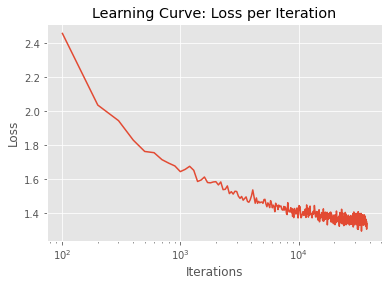

In [ ]:
plt.title("Learning Curve: Loss per Iteration")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.xscale('log')
plt.show()

### Training the same model and computing accuracy

We made sure to checkpoint, so now we can continue to train, but with our train_with_accuracy function, which computes training/validation accuracy as well.

In [ ]:
model = TextGenerator(train_vocab_size, 128, 256)
model.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/checkpoints3/ckpt-37700.pk'))

<All keys matched successfully>

In [ ]:
total_loss, iter_sub, total_acc, val_acc = train_with_accuracy(model,train_data,num_epochs=1,lr=0.001,checkpoint_path="/content/gdrive/My Drive/CSC413/checkpoints3.1/ckpt-{}.pk", max_iter=1500)

[Iter 101] Loss 1.317123
[Iter 101] Train Acc 0.586077
[Iter 101] Validation Acc 0.579209
    long was beautiful

on the one that you're my heart was good at all away
and you were here in mem
and take out the time
oh yeah
baby he's bo
[Iter 201] Loss 1.341765
[Iter 201] Train Acc 0.582291
[Iter 201] Validation Acc 0.578503
    put your own wells close
the guns of much to the good times to be falls

here in the night

in the same way now some
watching behind it as t
[Iter 301] Loss 1.310913
[Iter 301] Train Acc 0.585007
[Iter 301] Validation Acc 0.584872
    it always burn for her and home is to come
what it's the ones in the sky
my love i have no more

straight as people below for you
try we ope
[Iter 401] Loss 1.344216
[Iter 401] Train Acc 0.583271
[Iter 401] Validation Acc 0.582188
    [phant-fuck music and self smile

from lost down to gold
my kind up same oily
i desire my way
i'm missing the fool sound lord, love is my na
[Iter 501] Loss 1.337127
[Iter 501] Train Acc 0.581898
[Iter

### Learning Curve with Accuracy

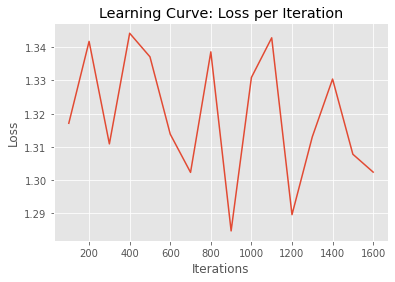

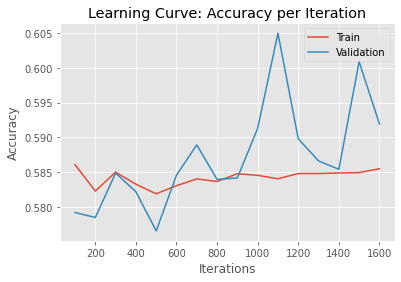

In [ ]:
plot_learning_curve(total_loss, iter_sub, total_acc,val_acc)

Our best model here was at iteration 901 with a loss equal to roughly 1.28, and training/validation accuracy both at roughly 58%.

# Sample Outputs from best models

During training, we made sure to checkpoint, so we compiled all our best models into a single folder, best_models, which we can now load into memory and compare.

## Model 1: hidden size = 256, loss = 1.28, train accuracy = 58%, validation accuracy = 58%

In [ ]:
model = TextGenerator(train_vocab_size, 128, 256)
model.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/best_models/ckpt-900.pk'))

<All keys matched successfully>

In [ ]:
sample_sequence(model, train_stoi,train_itos, 200, 0.8)

"shove christmas man\nbut i should touch it all so behind to rage\nthey'll leave and see\nearate my side\nit's alright into the clocks\nin the moon, for a book in his own\nhere i will show it\ni feel life is "

## Model 2: hidden size = 256, loss = 1.26, train accuracy = 59%, validation accuracy = 56%




In [ ]:
model2 = TextGenerator(train_vocab_size, 128, 256)
model2.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/best_models/ckpt-100.pk'))

<All keys matched successfully>

In [ ]:
sample_sequence(model2, train_stoi,train_itos, 200, 0.8)

"you know it was there\nand i'm not for a shout by duck for the end\n\nhere i belong\nthat shouts out of those side\nthe troubles you tried you and it's jesus\ni need for me forever and need it with face\n\nro"

# Best Model: Model 1

We chose Model 1 since it had a low loss (not the lowest, but low 'enough'), and had consistent accuracy between the training and validation sets. Now, let's see how the model performs with our test set:

## Test Accuracy

In [ ]:
def calc_train_acc(model,vocab_size,train_stoi,train_itos, test_data=test_data,
                        test_field=test_field, batch_size=1,max_it=None):
    test_data_size = len(test_data)
    test_data_iter = torchdata.BucketIterator(test_data,
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.Lyric),
                              sort_within_batch=True)
    avg_acc = []
    test_acc = []
    def convert_test_to_train(dataset):
      return [train_stoi[train_itos[data]] for data in dataset]

    it = 0
    its = []
    for (train_data, _),_ in test_data_iter:
        it +=1
        target = train_data.long()[0][1:].reshape(1,train_data.size()[1]-1)
        inp = train_data.long()[0][:-1].reshape(1,train_data.size()[1]-1)
        output,_ = model(inp,None)
        pred = torch.argmax(output.reshape(-1, vocab_size),dim=1)
        pred = pred.detach().numpy()
        pred = np.apply_along_axis(convert_test_to_train,0,pred)
        target = target.detach().numpy()
        target = np.apply_along_axis(convert_test_to_train,0,target)
        test_acc.append(np.sum(pred==target)/pred.size)
        if it % 100 == 0:
          its.append(it)
          avg_acc.append(float(sum(test_acc)/100))
          print(f"[itr {its[-1]-100}-{its[-1]}] Acc: {avg_acc[-1]}")
          test_acc = []
          if max_it and it > max_it:
            break
    return its,avg_acc, (sum(avg_acc)/len(avg_acc))

In [ ]:
len(test_data)

19619

In [ ]:
its,accs,avg_acc = calc_train_acc(model,train_vocab_size,train_stoi,train_itos)

[itr 0-100] Acc: 0.5772580086658895
[itr 100-200] Acc: 0.5933480465213744
[itr 200-300] Acc: 0.5779272363096856
[itr 300-400] Acc: 0.5919019181305216
[itr 400-500] Acc: 0.5929484298745169
[itr 500-600] Acc: 0.5908191068556635
[itr 600-700] Acc: 0.583396297026222
[itr 700-800] Acc: 0.5952630804069297
[itr 800-900] Acc: 0.589585059363645
[itr 900-1000] Acc: 0.5879391166893043
[itr 1000-1100] Acc: 0.5842907558676907
[itr 1100-1200] Acc: 0.5896029163258872
[itr 1200-1300] Acc: 0.58935587119405
[itr 1300-1400] Acc: 0.592683556198174
[itr 1400-1500] Acc: 0.5875447649698542
[itr 1500-1600] Acc: 0.5771866655365837
[itr 1600-1700] Acc: 0.5917701902594167
[itr 1700-1800] Acc: 0.580558016414635
[itr 1800-1900] Acc: 0.5888936657349275
[itr 1900-2000] Acc: 0.5815878392595779
[itr 2000-2100] Acc: 0.5862613688975213
[itr 2100-2200] Acc: 0.5812938930292795
[itr 2200-2300] Acc: 0.5932333582473397
[itr 2300-2400] Acc: 0.579790342701924
[itr 2400-2500] Acc: 0.5831030544721303
[itr 2500-2600] Acc: 0.58238

In [ ]:
its = [x for x in range(100,19601,100)]

### Testing Accuracy Plot

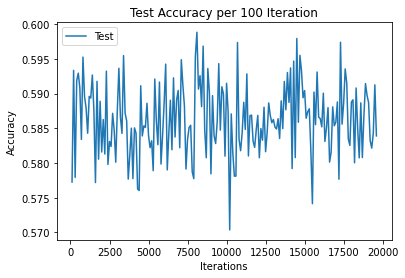

In [ ]:
plt.title("Test Accuracy per 100 Iteration")
plt.plot(its, accs, label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [ ]:
avg_acc

0.5862728751726942

So, on average our model gets a testing accuracy of roughly 58.6%, which is interestingly consistent with our validation accuracy as well.

## Generating Songs

Finally, we're going to reload our model, and see what kinds of lyrics it can come up with when given the average character length of our dataset: 

In [ ]:
model = TextGenerator(train_vocab_size, 128, 256)
model.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/best_models/ckpt-900.pk'))

<All keys matched successfully>

In [ ]:
print(sample_sequence(model, train_stoi,train_itos, 1078, 0.8))

we're gonna stop, a way
put me to the stars are closing in love do
the hatter now to leave you
you're closing on a flower
crawl that crease to me

i'm gonna be love somebody has come
over the sun rebel his christmas lit me
it surere chains on a fighters define
and we're gonna be
no soul and time here
no passing down to your mind can you see me, how day to bring me

birds with needing through this way
and say the sun
i don't watch so is what you got to be
she said my life when you done wasting and strarc

and i just want you to do
they called check it, you do


In [ ]:
print(sample_sequence(model, train_stoi,train_itos, 1078, 0.8))

heories and love is the patric inside
is all about
this ones in me i drink the light
you'll know me down
i am wonderful in the cobo
then i can't see that will all there's no
infeated, shoot me
what my love is mine
i ast and we could take my love

here i beautiffuck the light
no ground can be sure i forget
and i pray the shadows cross the fear and a pain
she was in the blue more to the world

ah ah oh oh
hey let me see me down

catch me lying
we'll do
well i can see you home
somebody like a lady, i burnly broken and free
your brother shadow with no short
we believe i felt right now

sings the world is those this
i need you heart is the man reach you and it said

but i can't i belong, take the wings
i never remember

there was no heart
the rest in the mosanter
oh so don't you used to be all the easy
as you cared in

how much i wouldn't erase you for a devade maces


watching the wartingly in the sign memorioana
sold at all

in the last right through
i got my way to the way it should sing

In [ ]:
print(sample_sequence(model, train_stoi,train_itos, 1078, 0.8))

in my face for a hole road one supersiant in the side
we will rele and so so long time
out of the end
make a pain

one hunger higher and some money
they of with the sky
i know it runs the hurting
let your bad start to see
i'm bashin' sing


and there things be here to kill my soul
the fire we track the air
i don't have it all lay to my eyes
this from alone chick
some may pill and from him
on the song were living answer

you can silent rain
like end it's pain
and with it rising
if you are the strength to ever ask into my fire

suff my eyes
love come anything
the darkness blaze with me
but i love you better goin' more than break
and the way i don't fall down
just more and it's a party of my life and rose on the devil
you'll find, his time and painful the show

i didn't have to forget
poor words axe the river
in the light is even takes a star
every sinking with tripple more

can we go who will never leave
you find that deligian
and i'm like a beautiful
come home with me
i won't be aliver 